In [53]:
import torch
import torch.nn as nn 
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from tqdm.auto import tqdm

In [2]:
model = models.vgg19().features

In [3]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [55]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.chosen_features = ['0', '5', '10', '19']
        self.model = models.vgg19().features[:21]

    def forward(self, x):
        features = []
        
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 356

loader = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[], std=[])
    ]
)

def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)

original_img = load_image("temp.jpeg")
style_img = load_image("style.jpeg")
generated = original_img.clone().requires_grad_(True)

# Hyperparameters 
total_steps = 100
learning_rate = 0.001
alpha = 1
beta = 0.04
optimizer = optim.Adam(params=[generated], lr=learning_rate)
model = VGG().to(device).eval()  # eval to freeze the weights

for step in tqdm(range(total_steps)):
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    style_loss = original_loss = 0
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean( (gen_feature - orig_feature)**2 )

        # Compute Gram Matrix
        G = gen_feature.view(channel, height*width) @ gen_feature.view(channel, height*width).T

        A = style_feature.view(channel, height*width) @ style_feature.view(channel, height*width).T
        style_loss += torch.mean((G - A)**2)

    total_loss = alpha * original_loss + beta * style_loss
    print(f"the loss -> {total_loss.item()}")
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    

    if step % 200 == 0:
        print(total_loss)
        save_image(generated, "Generated_image.png")




  0%|          | 0/100 [00:00<?, ?it/s]

the loss -> 31798.7265625
tensor(31798.7266, grad_fn=<AddBackward0>)
the loss -> 31343.958984375
the loss -> 30893.474609375
the loss -> 30447.33984375
the loss -> 30005.591796875
the loss -> 29568.28515625
the loss -> 29135.466796875
the loss -> 28707.177734375
the loss -> 28283.439453125
the loss -> 27864.3125
the loss -> 27449.8125
the loss -> 27039.96484375
the loss -> 26634.806640625
the loss -> 26234.353515625
the loss -> 25838.619140625
the loss -> 25447.626953125
the loss -> 25061.37890625
the loss -> 24679.884765625
the loss -> 24303.14453125
the loss -> 23931.162109375
the loss -> 23563.93359375
the loss -> 23201.451171875
the loss -> 22843.705078125
the loss -> 22490.68359375
the loss -> 22142.37109375
the loss -> 21798.75
the loss -> 21459.798828125
the loss -> 21125.5
the loss -> 20795.826171875
the loss -> 20470.74609375
the loss -> 20150.23046875
the loss -> 19834.248046875
the loss -> 19522.767578125
the loss -> 19215.751953125
the loss -> 18913.1640625
the loss -> 1861

In [59]:
for step in tqdm(range(total_steps)):
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    style_loss = original_loss = 0
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean( (gen_feature - orig_feature)**2 )

        # Compute Gram Matrix
        G = gen_feature.view(channel, height*width) @ gen_feature.view(channel, height*width).T

        A = style_feature.view(channel, height*width) @ style_feature.view(channel, height*width).T
        style_loss += torch.mean((G - A)**2)

    total_loss = alpha * original_loss + beta * style_loss
    print(f"the loss -> {total_loss.item()}")
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    

    if step % 10 == 0:
        print(total_loss)
        save_image(generated, "Generated_image.png")

  0%|          | 0/100 [00:00<?, ?it/s]

the loss -> 6507.2646484375
tensor(6507.2646, grad_fn=<AddBackward0>)
the loss -> 6402.47119140625
the loss -> 6299.3828125
the loss -> 6197.9716796875
the loss -> 6098.2109375
the loss -> 6000.076171875
the loss -> 5903.541015625
the loss -> 5808.58154296875
the loss -> 5715.1708984375
the loss -> 5623.2861328125
the loss -> 5532.90234375
tensor(5532.9023, grad_fn=<AddBackward0>)
the loss -> 5443.99658203125
the loss -> 5356.5439453125
the loss -> 5270.52490234375
the loss -> 5185.91357421875
the loss -> 5102.68994140625
the loss -> 5020.830078125
the loss -> 4940.31396484375
the loss -> 4861.1201171875
the loss -> 4783.22607421875
the loss -> 4706.61376953125
tensor(4706.6138, grad_fn=<AddBackward0>)
the loss -> 4631.26171875
the loss -> 4557.14990234375
the loss -> 4484.2568359375
the loss -> 4412.56591796875
the loss -> 4342.05712890625
the loss -> 4272.7099609375
the loss -> 4204.50732421875
the loss -> 4137.431640625
the loss -> 4071.464599609375
the loss -> 4006.587890625
tensor

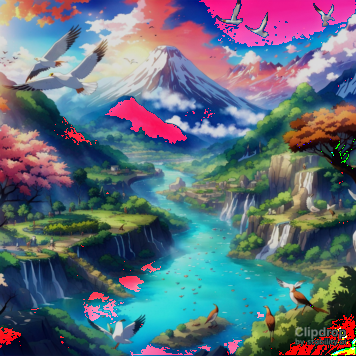

In [60]:
topiil = transforms.ToPILImage()
topiil(generated.detach().squeeze())